Итоговый результат использовал GroupKFold и определенный набор признаков.

In [1]:
import pandas as pd
import numpy as np
import catboost
import pickle
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [2]:
train = pd.read_csv(r'D:\data science\IOAI_DZ\Lesson 3, Homework\train.csv')
test = pd.read_csv(r'D:\data science\IOAI_DZ\Lesson 3, Homework\test.csv')
smp = pd.read_csv(r'D:\data science\IOAI_DZ\Lesson 3, Homework\sample_submission.csv')
train = train.sample(frac = 1.0, random_state = 322).reset_index(drop = True)
def lgb_train(train, target, split_list, param):

    bst_list = []
    for i , (train_index, test_index) in tqdm(enumerate(split_list), total=len(split_list)):

        tr = catboost.Pool(train[train_index], label = target[train_index])
        te = catboost.Pool(train[test_index], label = target[test_index])

        bst = catboost.train(tr, param, eval_set = te, iterations = 4000, early_stopping_rounds = 300, verbose =300)
        bst_list += [bst]

        gc.collect()
        del tr, te

    return bst_list

params_cat = {
    'loss_function' :'MultiClass',
    'task_type' : 'GPU',
     'max_depth' : 4,
    'eval_metric' :'MultiClass',
    'learning_rate' : .1,
    'border_count' :  127,
    'random_state' : 42 ,
}

In [3]:
smp

,id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_10,target_11,target_12,target_13,target_14,target_15,target_16,target_17,target_18,target_19
0,12792_0,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,12792_1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,12792_2,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,12792_3,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,12792_4,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147459,18474_4503,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
147460,18474_4504,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
147461,18474_4505,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
147462,18474_4506,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [113]:
from sklearn.model_selection import GroupKFold

def standart_split1(data, target, n_splits=5, seed=322):
    split_list = []
    gkf = GroupKFold(n_splits=n_splits)
    groups = data['session_id']
    for train_index, val_index in gkf.split(data, target, groups):
        split_list.append((train_index, val_index))
    return split_list

In [114]:
drop_cols = ['session_id', 'target']
train_cols = [x for x in train.columns if x not in drop_cols]

print(len(train_cols))

38


In [115]:
split_list = standart_split1(train, train['target'])
bst_list = lgb_train(train[train_cols].values, train['target'].values, split_list, params_cat)
pred = []
for bst in bst_list:
    pred += [bst.predict(test[train_cols], prediction_type = 'Probability') ]
smp[smp.columns[1:]] = np.mean(pred, 0)
smp.to_csv('submission.csv', index = None)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 2.6148610	test: 2.6234107	best: 2.6234107 (0)	total: 11.1ms	remaining: 44.5s
300:	learn: 0.7076224	test: 1.0212595	best: 1.0210072 (299)	total: 2.94s	remaining: 36.2s
600:	learn: 0.5525032	test: 1.0283273	best: 1.0174248 (399)	total: 5.85s	remaining: 33.1s
bestTest = 1.01742477
bestIteration = 399
Shrink model to first 400 iterations.
0:	learn: 2.6170263	test: 2.5973046	best: 2.5973046 (0)	total: 11.3ms	remaining: 45.4s
300:	learn: 0.7151862	test: 0.9116115	best: 0.9116115 (300)	total: 2.98s	remaining: 36.6s
600:	learn: 0.5604021	test: 0.8935311	best: 0.8927994 (582)	total: 5.83s	remaining: 33s
bestTest = 0.8927993851
bestIteration = 582
Shrink model to first 583 iterations.
0:	learn: 2.6138176	test: 2.6171095	best: 2.6171095 (0)	total: 10.9ms	remaining: 43.6s
300:	learn: 0.7149174	test: 0.8926480	best: 0.8926480 (300)	total: 2.87s	remaining: 35.2s
600:	learn: 0.5575475	test: 0.8653846	best: 0.8648870 (599)	total: 5.68s	remaining: 32.1s
900:	learn: 0.4617243	test: 0.8681659	b

In [116]:

def get_feature_importance(bst_list, feature_names):
    """
    Extract feature importance from CatBoost models.
    """
    importances = np.zeros(len(feature_names))
    for bst in bst_list:
        importances += np.array(bst.get_feature_importance())
    importances /= len(bst_list)
    return pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display feature importance
feature_importance = get_feature_importance(bst_list, train_cols)
feature_importance

,Feature,Importance
20,gyro_z_100_mean,23.767620
0,time,5.601437
1,accel_y_1_min,4.178819
6,accel_z_10_mean,4.139051
3,accel_z_10_min,2.902527
11,accel_y_10_min,2.836678
36,accel_y_60_median,2.834392
25,gyro_z_60_mean,2.702822
10,accel_x_10_mean,2.655901
2,accel_z_1_min,2.573098


по важности фичей попробую удалить фичу, которая имеет наибольший вес, еще другие фичи, которые имеют mean и умеют большую важность.

In [117]:
# подобал фичи и метод валидации

In [8]:
drop_cols = ['session_id', 'target','gyro_z_100_mean','accel_z_10_mean','accel_y_10_mean','accel_z_10_min','accel_x_10_mean','accel_z_1_min']
train_cols = [x for x in train.columns if x not in drop_cols]

print(len(train_cols))

32


In [9]:
# def stratified_split(data, target, n_splits=5, seed=322):
#     split_list = []
#     sgkf = StratifiedGroupKFold(n_splits=n_splits, random_state=seed, shuffle=True)
#     groups = data['session_id'].values  # Assuming 'session_id' is the grouping column
#     for train_index, val_index in sgkf.split(data, target, groups):
#         split_list.append((train_index, val_index))
#     return split_list

In [10]:
# from sklearn.model_selection import LeaveOneGroupOut
# """LeaveOneGroupOut"""
# def LeaveOneGroupOut_asd(data, target, n_splits = 5, seed = 322):
#     split_list = []
#     kf = LeaveOneGroupOut()
#     for train_index, val_index in kf.split(data, y = target, groups = data['session_id']):
#         split_list += [(train_index, val_index)]
#     return split_list


In [11]:
from sklearn.model_selection import GroupKFold

def standart_split(data, target, n_splits=5, seed=322):
    split_list = []
    gkf = GroupKFold(n_splits=n_splits)
    groups = data['session_id']
    for train_index, val_index in gkf.split(data, target, groups):
        split_list.append((train_index, val_index))
    return split_list

In [12]:
split_list = standart_split(train, train['target'])
bst_list = lgb_train(train[train_cols].values, train['target'].values, split_list, params_cat)
pred = []
for bst in bst_list:
    pred += [bst.predict(test[train_cols], prediction_type = 'Probability') ]
smp[smp.columns[1:]] = np.mean(pred, 0)
smp.to_csv('submission.csv', index = None)

  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 2.7032608	test: 2.7114723	best: 2.7114723 (0)	total: 10.3ms	remaining: 41.1s
300:	learn: 1.1488030	test: 1.5868820	best: 1.5851419 (262)	total: 2.77s	remaining: 34s
bestTest = 1.585141939
bestIteration = 262
Shrink model to first 263 iterations.
0:	learn: 2.7091738	test: 2.6978943	best: 2.6978943 (0)	total: 10.6ms	remaining: 42.4s
300:	learn: 1.1575450	test: 1.4692763	best: 1.4680572 (296)	total: 2.77s	remaining: 34s
600:	learn: 0.9581836	test: 1.4775058	best: 1.4670422 (345)	total: 5.46s	remaining: 30.9s
bestTest = 1.467042242
bestIteration = 345
Shrink model to first 346 iterations.
0:	learn: 2.7026821	test: 2.7076431	best: 2.7076431 (0)	total: 10.8ms	remaining: 43.3s
300:	learn: 1.1498517	test: 1.4412806	best: 1.4410830 (299)	total: 2.76s	remaining: 33.9s
600:	learn: 0.9467301	test: 1.4307385	best: 1.4294251 (491)	total: 5.46s	remaining: 30.9s
bestTest = 1.429425112
bestIteration = 491
Shrink model to first 492 iterations.
0:	learn: 2.7010789	test: 2.7090902	best: 2.709090

In [13]:

def get_feature_importance(bst_list, feature_names):
    """
    Extract feature importance from CatBoost models.
    """
    importances = np.zeros(len(feature_names))
    for bst in bst_list:
        importances += np.array(bst.get_feature_importance())
    importances /= len(bst_list)
    return pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Display feature importance
feature_importance = get_feature_importance(bst_list, train_cols)
feature_importance

,Feature,Importance
4,accel_z_10_median,8.044295
5,accel_y_10_median,7.718508
0,time,7.626979
3,accel_z_1_mean,5.386890
1,accel_y_1_min,5.060285
23,accel_x_10_min,4.458912
17,accel_y_100_min,3.799090
6,accel_y_10_min,3.713347
12,accel_x_10_std,3.665376
22,accel_x_100_median,3.361026


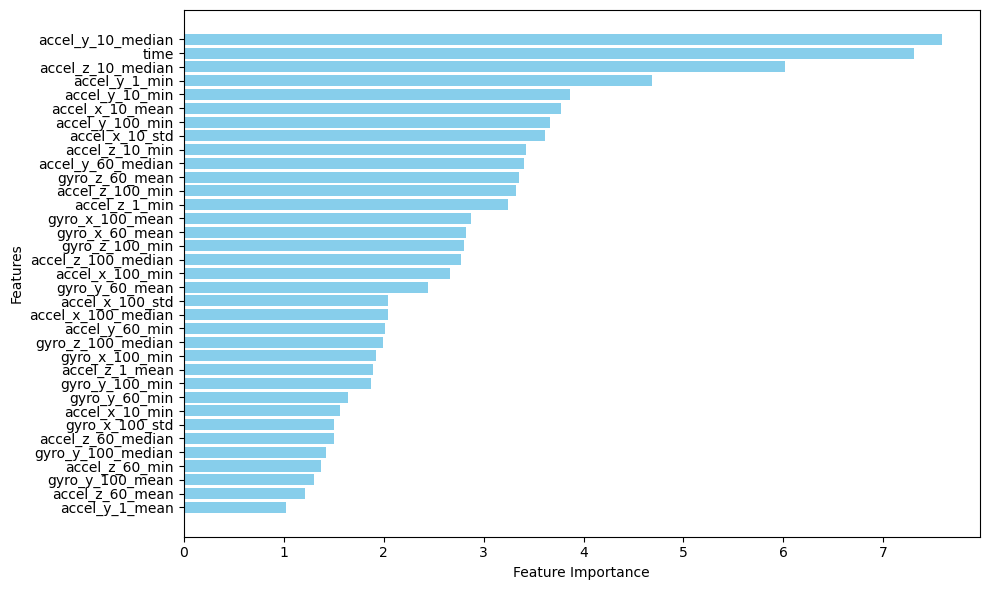

In [125]:
import matplotlib.pyplot as plt

# Function to plot feature importance
def plot_feature_importance(feature_importance):
    """
    Plots the top N most important features from the feature importance DataFrame.
    """
    # Select top N features
    top_features = feature_importance
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')

    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
    plt.tight_layout()
    plt.show()

# Plot feature importance (Top 20 features)
plot_feature_importance(feature_importance)